Simulating Stochastic Models:
This code simulates Daily stock price movements over a year (252 trading days) based on the GBM model.

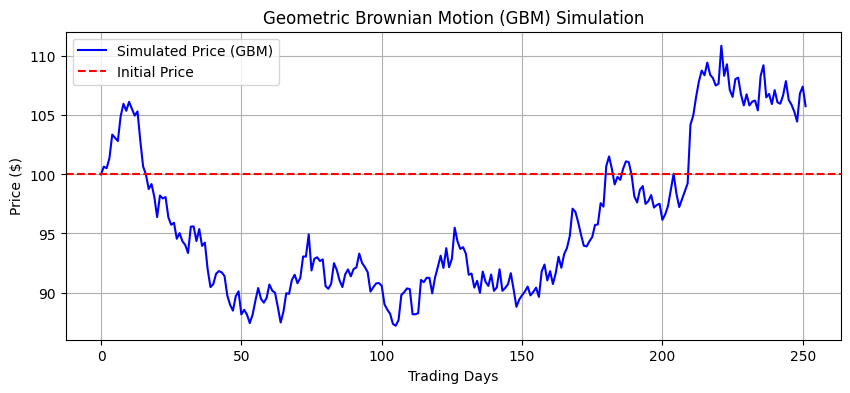

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters.
initial_price = 100
days = 252                      # Trading days in a year
mu = 0.10                       #Assuming 10% yearly growth (Annual drift)
sigma = 0.2                     # Annual volatility (20%) (This means prices go up and down randomly. 
                                # The higher the value, the more volatile the stock)
dt = 1/days                     # Since a full year is 1, one day is just 1/252 of a year.

# GBM Simulation
np.random.seed(42)              # Seed for reproducibility, it will generate the same random numbers every time.
price = np.zeros(days)          # Empty list to store the price values..
price[0] = initial_price        # Set the initial price
for t in range(1, days):        # Loop through the days
    drift = (mu - 0.5 * sigma**2) * dt                  # Drift ---> It ensures that the prices have a general upward trend over time
    shock = sigma * np.random.normal(0, np.sqrt(dt))    # Shock ---> Its a random ups and downs in price (like real stock markets).
                                                        # Shock = Weimer Process
    price[t] = price[t-1] * np.exp(drift + shock)       # Price at time t = Price at time t-1 * e^(drift + shock)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(price, color='blue', label='Simulated Price (GBM)')
plt.axhline(initial_price, linestyle='--', color='red', label='Initial Price')
plt.xlabel('Trading Days')
plt.ylabel('Price ($)')
plt.title('Geometric Brownian Motion (GBM) Simulation')
plt.legend()
plt.grid(True)
plt.show()

Simulating Stochastic Models: Heston Model Simulation:
This code simulates daily stock price movements over a year (252 trading days) using the Heston model, which extends the GBM framework by incorporating stochastic volatility through correlated random processes.


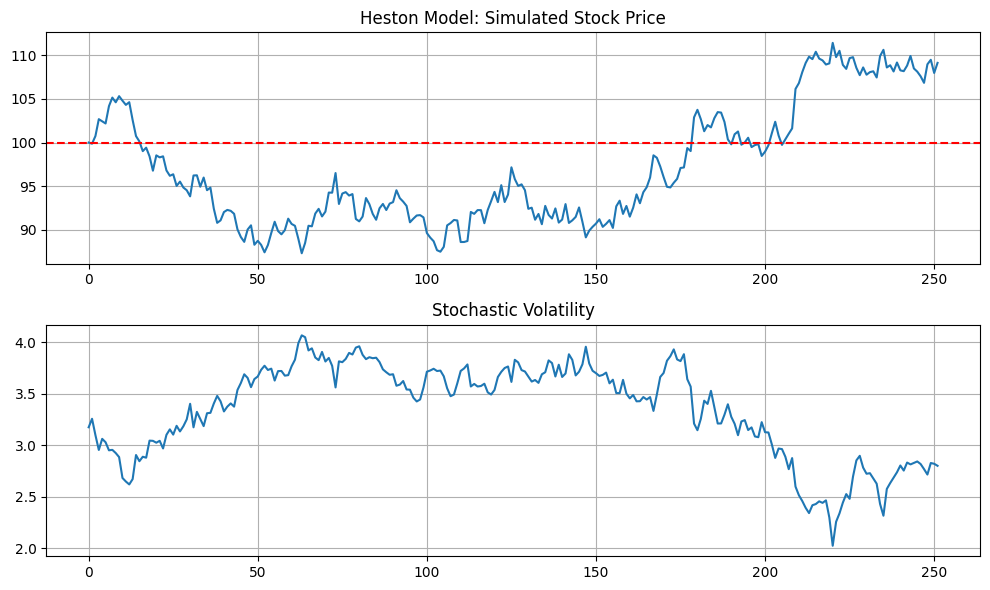

In [89]:
def heston_model(S0, v0, mu, kappa, theta, sigma, rho, T, dt):
    n_steps = int(T/dt)         # Number of steps
    S = np.zeros(n_steps)       # Empty list to store the price values
    v = np.zeros(n_steps)       # Empty list to store the volatility values
    S[0] = S0                   # Set the first stock price as initial price  
    v[0] = v0                   # Set the first volatility as initial volatility

    # Correlated Wiener processes
    np.random.seed(42)                                                                  # Seed for reproducibility    
    dw1 = np.random.normal(0, np.sqrt(dt), n_steps)                                     # Brownian motion 1
    dw2 = rho * dw1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), n_steps)   # Brownian motion 2

    for t in range(1, n_steps):
        dv = kappa * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1]) * dw2[t]       # Stochastic volatility       
        v[t] = max(v[t-1] + dv, 0)                                              # Ensuring that the volatility is non-negative
        dS = mu * S[t-1] * dt + np.sqrt(v[t-1]) * S[t-1] * dw1[t]               # Stock price dynamics                 
        S[t] = S[t-1] + dS

    return S, v

# Parameters
S0 = 100      # Initial price
v0 = 0.04     # Initial volatility (sqrt(0.04) = 20% annualized)
mu = 0.10     #Assuming 10% yearly growth (Annual drift)
kappa = 3.0   # It controls how fast volatility returns to its average value. (If volatility goes too high, κ pulls it down and VV)
              # Stable Market = High Kappa
theta = 0.04  # Long-term volatility
              # If θ is lower, the stock market is expected to be more stable. (Less theta, more stable)
sigma = 0.2   # Volatility of volatility (how much volatility fluctuates)
rho = -0.7    # A negative correlation means that when stock prices drop, volatility increases 
              # (this is called the "leverage effect" in finance).
              # In a financial crisis, σ is high (volatility jumps suddenly).
T = 1         # Time horizon (1 year)
dt = 1/252    # Daily steps (252 trading days)

# Simulate
price, volatility = heston_model(S0, v0, mu, kappa, theta, sigma, rho, T, dt)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(price)
ax1.axhline(initial_price, linestyle='--', color='red', label='Initial Price')
ax1.grid(True)
ax1.set_title('Heston Model: Simulated Stock Price')
ax2.plot(np.sqrt(volatility * 252))  # Annualized volatility
ax2.set_title('Stochastic Volatility')
plt.tight_layout()
plt.grid(True)
plt.show()

Simulating Agent-Based Financial Market: ABM Simulation
This code simulates a financial market over 252 trading days using an agent-based model with fundamentalists, chartists, and noise traders, where agents make trading decisions that adjust the price based on aggregated buy and sell orders.


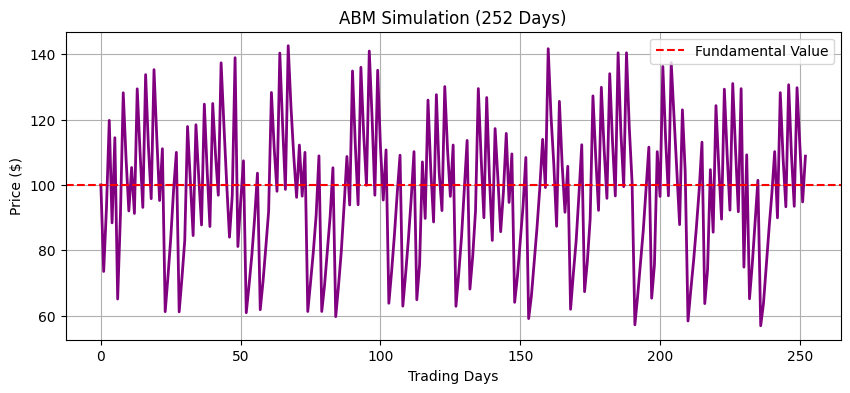

In [90]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, agent_type, risk_aversion): # Initialize the agent
        self.type = agent_type              # Type of agent (fundamentalist, chartist, noise)
        self.risk_aversion = risk_aversion  # How much risk the agent is willing to take
        self.wealth = 1000                  # Initial wealth

    def decide_order(self, current_price, historical_prices):   # Decide whether to buy or sell
        if self.type == 'fundamentalist':                       
            fundamental_value = 100  # Baseline value           
            if current_price < fundamental_value:
                return 'buy', np.random.randint(5, 15)  # Buy more if undervalued
            else:
                return 'sell', np.random.randint(5, 15)
        elif self.type == 'chartist':
            if len(historical_prices) > 5:
                trend = np.mean(historical_prices[-5:]) > np.mean(historical_prices[-10:-5])    # Check for short-term trend
                return 'buy' if trend else 'sell', np.random.randint(3, 8)                      # Buy if going up, sell if going down
            else:
                return 'hold', 0
        else:  # Noise trader
            return np.random.choice(['buy', 'sell']), np.random.randint(1, 5)               # Randomly buy or sell

def simulate_abm(num_agents=200, days=252):             # Agent-based model simulation
    agents = [
        Agent(
            agent_type=np.random.choice(['fundamentalist', 'chartist', 'noise'], p=[0.3, 0.3, 0.4]),
            risk_aversion=np.random.uniform(0.1, 0.5)           # Aggressive (low risk aversion) → Follows strong trends.
                                                                # Cautious (high risk aversion) → Waits for more confirmation before trading.

        )
        for _ in range(num_agents)
    ]

    price = 100
    historical_prices = [price]                 # Store the price history (Chartist uses this to determine trends)

    for day in range(days):
        buy_orders = 0
        sell_orders = 0

        for agent in agents:
            action, quantity = agent.decide_order(price, historical_prices)
            if action == 'buy':
                buy_orders += quantity
            elif action == 'sell':
                sell_orders += quantity

        # Smoother price adjustment (reduce sensitivity)
        excess_demand = buy_orders - sell_orders
        price = price * (1 + 0.0005 * excess_demand)  # Reduced from 0.001 to 0.0005
        historical_prices.append(price)

    return historical_prices

# Simulate and plot
np.random.seed(42)
prices = simulate_abm(num_agents=200, days=252)

plt.figure(figsize=(10, 4))
plt.plot(prices, color='purple', linewidth=2)
plt.title("ABM Simulation (252 Days)")
plt.xlabel("Trading Days")
plt.ylabel("Price ($)")
plt.grid(True)
plt.axhline(100, linestyle='--', color='red', label='Fundamental Value')
plt.legend()
plt.show()

Hybrid Model: GBM + ABM Simulation:
This code simulates daily stock price movements by combining a geometric Brownian motion (GBM) stochastic process with an agent-based model (ABM) component that accounts for trader behavior and net demand impact.


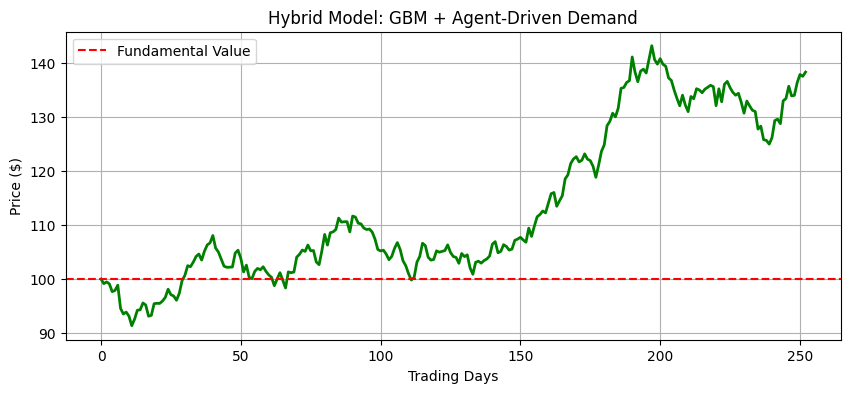

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Hybrid Model: GBM + ABM
class Agent:
    def __init__(self, agent_type):
        self.type = agent_type  # 'fundamentalist', 'chartist', 'noise', 'contrarian', 'institutional'
        self.wealth = 1000      # Initial wealth

    def decide_order(self, current_price, historical_prices):
        if self.type == 'fundamentalist':
            # Buy if under the fundamental value, sell if above.
            if current_price < 100:
                return 'buy', np.random.randint(5, 10)              # Buy more if undervalued
            else:
                return 'sell', np.random.randint(5, 10)             # Sell more if overvalued

        elif self.type == 'chartist':
            # Momentum strategy: if price is trending up, buy; if not, sell.
            if len(historical_prices) > 1 and historical_prices[-1] > historical_prices[-2]:
                return 'buy', np.random.randint(3, 6)
            else:
                return 'sell', np.random.randint(3, 6)

        elif self.type == 'contrarian':
            # Contrarian strategy: if price has risen, expect a reversal and sell; if fallen, buy.
            if len(historical_prices) > 1 and historical_prices[-1] > historical_prices[-2]:
                return 'sell', np.random.randint(3, 7)
            else:
                return 'buy', np.random.randint(3, 7)

        elif self.type == 'institutional':
            # Institutional traders use the fundamental value but trade in larger volumes.
            if current_price < 100:
                return 'buy', np.random.randint(10, 21)
            else:
                return 'sell', np.random.randint(10, 21)

        else:  # Noise trader (or any unspecified type)
            return np.random.choice(['buy', 'sell']), np.random.randint(1, 3)

def simulate_hybrid(num_agents=200, days=252):
    # Define agent type probabilities:
    # Fundamentalist: 25%, Chartist: 25%, Noise: 30%, Contrarian: 10%, Institutional: 10%
    agent_types = ['fundamentalist', 'chartist', 'noise', 'contrarian', 'institutional']
    probabilities = [0.40, 0.05, 0.20, 0.20, 0.15]

    # Initialize agents with the new type probabilities
    agents = [Agent(np.random.choice(agent_types, p=probabilities))
              for _ in range(num_agents)]

    # GBM parameters
    mu = 0.05       # Annual drift (5%)
    sigma = 0.2     # Annual volatility (20%)
    dt = 1/252      # Daily time step

    # Hybrid parameters
    beta = 0.001           # Sensitivity to agent actions
    total_shares = 10000   # Total shares in the market

    # Initialize price
    price = 100
    historical_prices = [price]

    for day in range(days):
        # Stochastic (GBM) Component
        drift = (mu - 0.5 * sigma**2) * dt
        shock = sigma * np.random.normal(0, np.sqrt(dt))
        stochastic_return = drift + shock

        # Agent-Driven Component
        buy_orders = 0
        sell_orders = 0
        for agent in agents:
            action, quantity = agent.decide_order(price, historical_prices)
            if action == 'buy':
                buy_orders += quantity
            else:
                sell_orders += quantity

        net_demand = buy_orders - sell_orders               # Net demand
        agent_impact = beta * (net_demand / total_shares)   # Agent-driven price impact, β=0.001 ensures agent impact remains small.


        # Update Price
        price = price * (1 + stochastic_return + agent_impact)  # Combine GBM and agent-driven impact
        historical_prices.append(price)                         # Store the price           

    return historical_prices

# Simulate and plot
np.random.seed(42)
prices = simulate_hybrid()

plt.figure(figsize=(10, 4))
plt.plot(prices, color='green', linewidth=2)
plt.title("Hybrid Model: GBM + Agent-Driven Demand")
plt.xlabel("Trading Days")
plt.ylabel("Price ($)")
plt.grid(True)
plt.axhline(100, linestyle='--', color='red', label='Fundamental Value')
plt.legend()
plt.show()
